### **This notebook looks into the timeseries of reply each poster got from IO account within different interval.**

In [1]:
import pandas as pd
import numpy as np
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from tqdm import tqdm
import sys
import os
import networkx as nx
import datetime

import importlib

#### packages
import helper.strategy_helper as st
import helper.visualization as vz
import helper.helper as hp
import helper.file_helper as file_hp
import config.config as config

##### **Read paths**Test campaign

In [2]:
config = config.config()
path = config['PATHS']

derived_path = path['derived_path']
all_tweet_data = path['all_tweet_data']
plot_path = path['plot_path']

##### **Read all campaigns**

In [3]:
all_campaigns, names = st.bundle_campaign()

##### **Create folder for plots**

In [4]:
file_hp.create_folder(plot_path, 
                      'reply_time_series')
time_plot_path = os.path.join(plot_path, 
                          'reply_time_series')

##### **Test campaign**

In [5]:
year = '2020_12'
campaign = 'iran_202012'
type_of = 'ops'

##### **Read IO data**

In [6]:
data_path = st.get_data_path(all_tweet_data, 
                                 year, 
                                 campaign)

df = st.read_ops_control_data(data_path['ops'],
                                data_path['control'], 
                             [type_of])['ops']

df_iran = st.reply_to_external_users(df)

In [7]:
df_iran.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89139 entries, 79 to 559907
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tweetid                   89139 non-null  int64  
 1   userid                    89139 non-null  int64  
 2   user_display_name         89139 non-null  object 
 3   user_screen_name          89139 non-null  object 
 4   user_reported_location    89139 non-null  object 
 5   user_profile_description  89139 non-null  object 
 6   user_profile_url          89139 non-null  object 
 7   follower_count            89139 non-null  int64  
 8   following_count           89139 non-null  int64  
 9   account_creation_date     89139 non-null  object 
 10  account_language          89139 non-null  object 
 11  tweet_language            89139 non-null  object 
 12  tweet_text                89139 non-null  object 
 13  tweet_time                89139 non-null  object 
 14  twee

In [8]:
df_iran = df_iran.astype({
    'in_reply_to_userid': int,
    'in_reply_to_tweetid': int
})

In [9]:
print('Min time ', df_iran['tweet_time'].min())
print('Max time ', df_iran['tweet_time'].max())

Min time  2010-07-28 23:43
Max time  2020-12-27 18:08


##### **Lets check how many replies each user got in a day (not considering unique tweetids)**

In [10]:
df_iran = st.add_YYYY_MM_DD(df_iran)

In [11]:
df_day_grp = (df_iran.groupby(['in_reply_to_userid', 
                              'tweet_time_year'])['in_reply_to_tweetid']
              .size()
              .to_frame('count')
              .reset_index()
             )

df_day_grp.head()

,in_reply_to_userid,tweet_time_year,count
0,767,2018-10-24,1
1,3839,2020-10-11,1
2,62653,2020-06-01,1
3,246103,2019-06-11,1
4,246103,2019-06-25,1


In [12]:
print('Max replies in  day ', df_day_grp['count'].max())

Max replies in  day  196


In [13]:
def plot_histogram(parameters):
    '''
    Plots histogram
    :param parameters: parameters for the plot
    '''
       
    # parameters =  {
    #     'data': df,
    #     'fontsize': 14,
    #     'columns': [
    #         {'column': 'count',
    #          'label': 'Count of Replies',
    #         }
    #     ],
    #     'xlabel': '',
    #     'ylabel': '',
    #     'legend_location': '',
    #     'log_yscale': True,
    #     'log_xscale': True,
    #     'bins': 60,
    #     'save': {
    #         'path': '',
    #         'filename': ''
    #     },
    #     'title': ''
    # }
    
    
    num_bins = parameters['bins']
    column = parameters['columns'][0]['column']
    df = parameters['data']
    
    if parameters['bins'] == None:
        num_bins = df[column].nunique()
        
    if parameters['log_xscale'] == True:
        num_bins=np.logspace(start=np.log10(min(df[column])), 
                             stop=np.log10(max(df[column])),
                             num=num_bins
                            )
    fig, ax = plt.subplots()
    
    n = ax.hist(df[column],
                bins=num_bins, 
               )
    ax.set_xlabel(parameters['xlabel'])
    ax.set_ylabel(parameters['ylabel'])
    
    if parameters['log_yscale'] == True:
        plt.yscale('log')
    if parameters['log_xscale'] == True:
        plt.xscale('log')
        
    plt.title(parameters['title'])
    
    plot_path = parameters['save']['path']
    title = parameters['save']['filename']
    
    path = os.path.join(plot_path, title)
    fig.savefig(f'{path}', 
              facecolor='white', 
              transparent=False)
    plt.show()

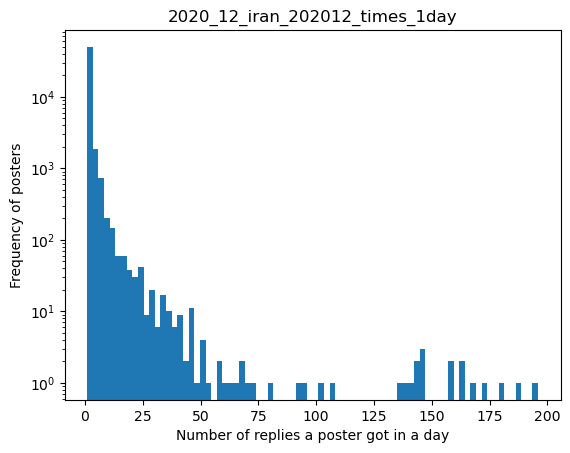

In [14]:
parameters =  {
    'data': df_day_grp,
    'fontsize': 14,
    'columns': [
        {'column': 'count',
         'label': 'Count of Replies',
        }
    ],
    'xlabel': 'Number of replies a poster got in a day',
    'ylabel': 'Frequency of posters',
    'legend_location': '',
    'log_yscale': True,
    'log_xscale': None,
    'bins': None,
    'title': f'{year}_{campaign}_times_1day',
    'save': {
        'path': f'{time_plot_path}',
        'filename': f'{year}_{campaign}_times_1day.png'
    },
}
    
plot_histogram(parameters)

How many replies each poster got in a day? <br />
Most of the poster got 1 to 25 replies in a day.

##### **How many replies a poster got in a day from each IO accounts?**

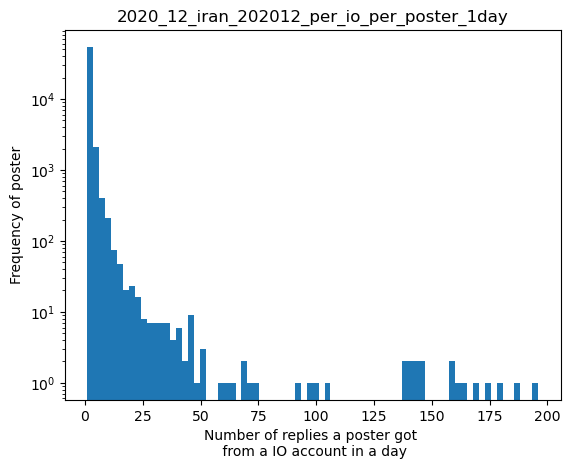

In [15]:
df_per_day_per_io = (df_iran.groupby([
    'userid',
    'in_reply_to_userid', 
    'tweet_time_year'])['in_reply_to_tweetid']
                     .nunique()
                     .to_frame('count')
                     .reset_index())
parameters =  {
    'data': df_per_day_per_io,
    'fontsize': 14,
    'columns': [
        {'column': 'count',
         'label': 'Count of Replies',
        }
    ],
    'xlabel': 'Number of replies a poster got \n from a IO account in a day',
    'ylabel': 'Frequency of poster',
    'legend_location': '',
    'log_yscale': True,
    'log_xscale': False,
    'bins': None,
    'title': f'{year}_{campaign}_per_io_per_poster_1day',
    'save': {
        'path': f'{time_plot_path}',
        'filename': f'{year}_{campaign}_per_io_per_poster_1day.png'
    },
}
    
plot_histogram(parameters)

**How many replies a poster got in a day from each IO accounts?** <br />
Most of the IO accounts replied from 1-25 times in a day to each user. <br />
Could there be a case that a poster is posting alot of tweets in a day. <br />
This plot is very similar to previous plot. The number of replies that poster got in a day is similar to number of replies from each IO account <br />
Is the poster being replied targeted on specific day?

##### **ALL campaign: How many IO accounts with 10 or more replies to each poster**

In [99]:
df_test = (df_iran.groupby([
    'userid',
    'in_reply_to_userid', 
    'tweet_time_year'])['in_reply_to_tweetid']
                     .nunique()
                     .to_frame('count')
                     .reset_index())

gt_10 = df_test.loc[df_test['count'] >= 10]

print('Greater than 10 tweets', len(gt_10))

Greater than 10 tweets 272


In [100]:
print('Total tweets ', gt_10['count'].sum())

Total tweets  7987


#### **Save conversation ids of posters that got more than 10  replies in a day**

In [122]:
df_conv_count = (df_iran.groupby(['userid',
                                  'in_reply_to_userid', 
                                  'tweet_time_year'])['in_reply_to_tweetid']
                 .nunique()
                 .to_frame('count')
                 .reset_index())

df_conv_count = df_conv_count.loc[
    df_conv_count['count'] >= 5]

df_conv_text = df_iran.merge(df_conv_count[['userid',
                                            'in_reply_to_userid',
                                            'tweet_time_year']],
                             on=['userid','in_reply_to_userid',
                                 'tweet_time_year'],)

In [123]:
df_test = (df_conv_text.groupby(['in_reply_to_userid', 
                                 'tweet_time_year'])['userid']
             .nunique()
             .to_frame('count')
             .reset_index()
            )



In [130]:
time = df_test.loc[df_test['count'] >= 4]['tweet_time_year']

time.values[0]

'2020-06-18'

In [131]:
df_conv_count.loc[df_conv_count['tweet_time_year'] == time.values[0]]

,userid,in_reply_to_userid,tweet_time_year,count
18450,853499764461142016,1160409968216018944,2020-06-18,5
18616,884782586328776709,1160409968216018944,2020-06-18,5
25520,1067743222317924352,1065513923728891904,2020-06-18,5
25638,1067743222317924352,1160409968216018944,2020-06-18,8
35114,1131190838829223938,25073877,2020-06-18,6
39219,1131190838829223938,1213566509693296640,2020-06-18,5
40999,1169137349508382720,1065513923728891904,2020-06-18,5
41023,1169137349508382720,1160409968216018944,2020-06-18,5
51862,1250951293218193411,1187437657514823680,2020-06-18,6


In [111]:
grps = df_conv_text.groupby(['in_reply_to_userid',
                      'tweet_time_year'])

for grp in grps:
    print('***********')
    print(grp[0])
    print('************')
    print(grp[1][['userid', 'tweet_text']])
    
    in = ra
    
    # break

***********


NameError: name 'group' is not defined

In [ ]:
rows = df.loc[
        df['in_reply_to_tweetid'] != 0]['in_reply_to_tweetid'].unique()

In [88]:
def test_count(path, external=True,
               threshold = 10):
    type_of = 'ops'
    info =[]

    all_campaigns, names = st.bundle_campaign()

    for row in all_campaigns:
        for year in row:
            for new_campaign in row[year]:

                print(f'\n ------START: {year}: {new_campaign} ------- \n')

                data_path = st.get_data_path(all_tweet_data, year, 
                                     new_campaign)

                data = st.read_ops_control_data(data_path['ops'],
                                                data_path['control'], 
                                             [type_of])
                df_w = data[type_of]
                
                if 'in_reply_to_tweetid' not in df_w.columns:
                    continue
                    
                if external == True:
                    df_w = st.reply_to_external_users(df_w)
            
                df_w = st.add_YYYY_MM_DD(df_w)
            
                df_test = (df_w.groupby(['userid', 
                                         'in_reply_to_userid', 
                                         'tweet_time_year'])['in_reply_to_tweetid']
                           .nunique()
                           .to_frame('count')
                           .reset_index())

                total = len(df_test.loc[df_test['count'] >= threshold])
                
                info.append([year, new_campaign, total])
   
                print(f'\n ------END: {year}: {new_campaign} ------- \n')

    (pd.DataFrame(data=info,
                  columns=['year', 'campaign', 
                           f'number_of_replies_to_poster_greater_than_10_in_a_day']
                 )
     .to_csv(f'{path}')
    )

In [90]:
threshold = 10

filename = f'{threshold}_or_more_replies_each_poster_got_in_a_day_from_each_io.csv'

file_path = os.path.join(derived_path, filename)

# test_count(file_path, external=True,
#                threshold = threshold)

In [97]:
#per day reply to each poster to each io
#shows have enough data

df_info = pd.read_csv(file_path)

df_info #['number_of_replies_to_poster_greater_than_10_in_a_day']

,Unnamed: 0,year,campaign,number_of_replies_to_poster_greater_than_10_in_a_day
0,0,2021_12,CNHU_0621,0
1,1,2021_12,CNCC_0621,68
2,2,2021_12,MX_0621,52
3,3,2021_12,REA_0621,2
4,4,2021_12,RNA_0621,0
5,5,2021_12,Tanzania_0621,16
6,6,2021_12,uganda_0621,338
7,7,2021_12,Venezuela_0621,432
8,8,2020_12,armenia_202012,4
9,9,2020_12,GRU_202012,3


##### **How many replies a poster got in an hour?**

In [16]:
def bin_replies_in_time(df, 
                       columns_to_include=['userid', 'tweetid'],
                       time_bin=24, time_part='H') -> dict:
    '''
    Bins the tweets based on time_bin
    
    :param time_bin: time to bin the tweets with
    
    :return dictionary with end time as key and dataframe of tweets within time range \
    as values
    '''
    
    df['tweet_time'] = pd.to_datetime(df['tweet_time'])
   
    #Time bins
    if time_part == 'H':
        delta_time = datetime.timedelta(hours=time_bin)
    else:
        delta_time = datetime.timedelta(0,1)
        
    time_lists = (pd.DataFrame(columns=['NULL'],
                               index=pd.date_range(df['tweet_time'].min(),
                                                   df['tweet_time'].max() + delta_time,
                                                freq =f'{time_bin}{time_part}'))
                  .index
                  .tolist())
                  
    
    #Filter tweets in bins
    new_column = columns_to_include + ['time_interval']
    df_time = pd.DataFrame(columns=new_column)
    
    for i in tqdm((range(1, len(time_lists)))):
        temp_df = df.loc[(time_lists[i-1] <= df['tweet_time']) & \
                           (df['tweet_time'] < time_lists[i])]

        if len(temp_df) <= 1:
            continue
            
        temp_df = temp_df[columns_to_include]
        temp_df['time_interval'] = time_lists[i]
        df_time = pd.concat([df_time, temp_df])

    return df_time

In [17]:
print('Min time ', df_iran['tweet_time'].min())
print('Max time ', df_iran['tweet_time'].max())

start_time = df_iran['tweet_time'].min() - pd.to_timedelta(30, unit="m")
end_time = df_iran['tweet_time'].max() + pd.to_timedelta(30, unit="m")

print('Start time ', start_time)
print('End time ', end_time)

time_interval = pd.date_range(
    start=start_time, 
    end=end_time, 
    freq='1H',
    inclusive='both'
)

df_time = pd.DataFrame(data=time_interval,
                       columns=['time_interval']
                      )
                       
    
df_time = df_time.sort_values(by='time_interval',
                              ascending=True
                             )
df_time['end_time'] = df_time['time_interval'].shift(-1)

df_time = df_time.dropna()

df_time = df_time.rename(
    columns={'time_interval': 'start_time'})

columns_to_include = ['in_reply_to_tweetid', 
                      'userid',
                      'in_reply_to_userid', 
                      'tweetid']

time_data = bin_replies_in_time(df_iran, 
                                columns_to_include,
                                time_bin=1, time_part='H')

time_data = time_data.reset_index(drop=True)

df_time_binned = (time_data.groupby(['in_reply_to_userid', 
                                     'time_interval'])['tweetid']
                  .size()
                  .to_frame('count')
                  .reset_index())

print('Maximum reply in 1 hour ', 
      df_time_binned['count'].max())

Min time  2010-07-28 23:43:00
Max time  2020-12-27 18:08:00
Start time  2010-07-28 23:13:00
End time  2020-12-27 18:38:00


100%|██████████| 91315/91315 [01:12<00:00, 1255.07it/s]


Maximum reply in 1 hour  158


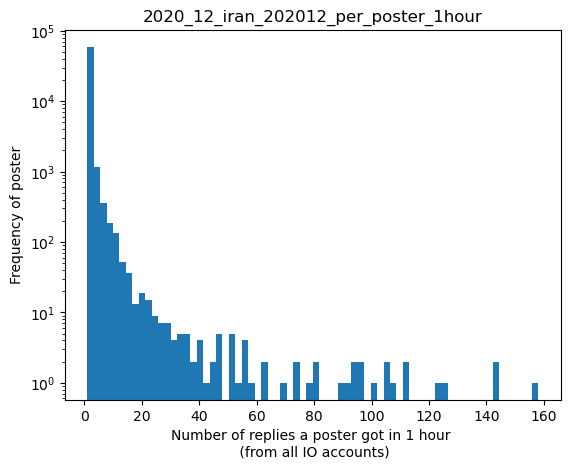

In [18]:
parameters =  {
    'data': df_time_binned,
    'fontsize': 14,
    'columns': [
        {'column': 'count',
         'label': 'Count of Replies',
        }
    ],
    'xlabel': 'Number of replies a poster got in 1 hour \n (from all IO accounts)',
    'ylabel': 'Frequency of poster',
    'legend_location': '',
    'log_yscale': True,
    'log_xscale': False,
    'bins': None,
    'title': f'{year}_{campaign}_per_poster_1hour',
    'save': {
        'path': f'{time_plot_path}',
        'filename': f'{year}_{campaign}_per_poster_1h.png'
    },
}
    
plot_histogram(parameters)

How many replies a poster got in an hour? <br />
- Most of the poster got 1 to 20 replies in an hour

##### **How many replies each poster got from each IO account in 1 hour?**

In [19]:
time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86020 entries, 0 to 86019
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   in_reply_to_tweetid  86020 non-null  object        
 1   userid               86020 non-null  object        
 2   in_reply_to_userid   86020 non-null  object        
 3   tweetid              86020 non-null  object        
 4   time_interval        86020 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 3.3+ MB


In [20]:
df_time_user_binned = (time_data.groupby(['in_reply_to_userid',
                                          'userid',
                                          'time_interval'])['tweetid']
                  .size()
                  .to_frame('count')
                  .reset_index())

print('Maximum reply in 1 hour ', 
      df_time_user_binned['count'].max())

Maximum reply in 1 hour  158


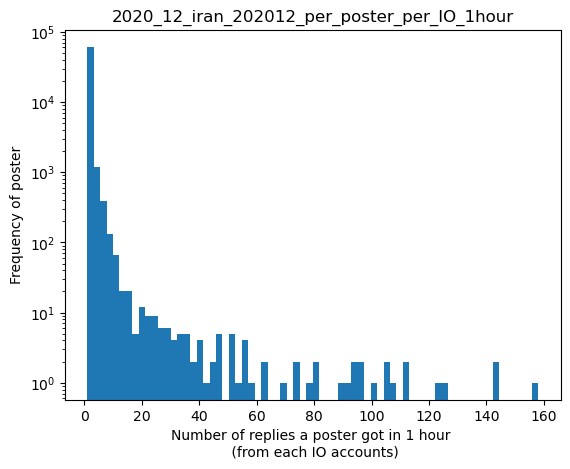

In [21]:
parameters =  {
    'data': df_time_user_binned,
    'fontsize': 14,
    'columns': [
        {'column': 'count',
         'label': 'Count of Replies',
        }
    ],
    'xlabel': 'Number of replies a poster got in 1 hour \n (from each IO accounts)',
    'ylabel': 'Frequency of poster',
    'legend_location': '',
    'log_yscale': True,
    'log_xscale': False,
    'bins': None,
    'title': f'{year}_{campaign}_per_poster_per_IO_1hour',
    'save': {
        'path': f'{time_plot_path}',
        'filename': f'{year}_{campaign}_per_io_per_poster_1h.png'
    },
}
    
plot_histogram(parameters)

In an hour most of the posters got 1 to 20 replies.

##### **How many unique tweets were replied to by IO accounts in a day?**
This could hints if the poster is posting more in a single day.

In [22]:
df_time_tweet_binned = (time_data.groupby(['in_reply_to_userid',
                                          'userid',
                                          'time_interval'])['in_reply_to_tweetid']
                  .nunique()
                  .to_frame('count')
                  .reset_index())

print('Maximum reply in 1 hour ', 
      df_time_tweet_binned['count'].max())

Maximum reply in 1 hour  158


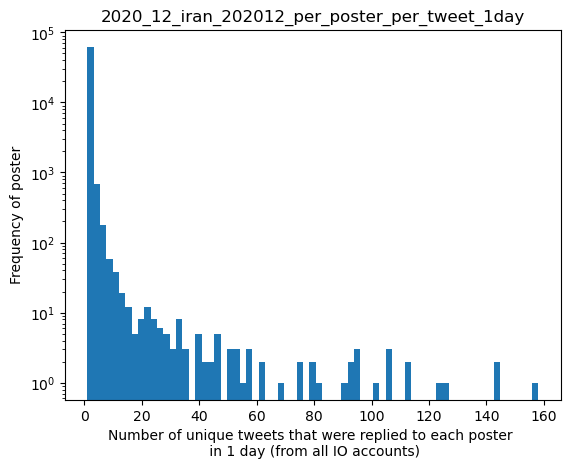

In [23]:
parameters =  {
    'data': df_time_tweet_binned,
    'fontsize': 14,
    'columns': [
        {'column': 'count',
         'label': 'Count of Replies',
        }
    ],
    'xlabel': 'Number of unique tweets that were replied to each poster \n in 1 day (from all IO accounts)',
    'ylabel': 'Frequency of poster',
    'legend_location': '',
    'log_yscale': True,
    'log_xscale': False,
    'bins': None,
    'title': f'{year}_{campaign}_per_poster_per_tweet_1day',
    'save': {
        'path': f'{time_plot_path}',
        'filename': f'{year}_{campaign}_per_tweet_per_poster_1day.png'
    },
}
    
plot_histogram(parameters)

In a day, 1 to 30 tweets are being replied to from IO accounts to each poster. <br />
This seems to be mass reply on specific day of posting tweets.

## **1 day analysis: Lets check Jaccard coefficient for each IO account. Only poster with 5 or more unique tweets in a day were considered for analysis**

In [26]:
df_iran.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_language',
       'tweet_text', 'tweet_time', 'tweet_client_name', 'in_reply_to_userid',
       'in_reply_to_tweetid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'latitude', 'longitude',
       'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags',
       'urls', 'user_mentions', 'tweet_time_year'],
      dtype='object')

In [27]:
df_day_grp = (df_iran.groupby(['in_reply_to_userid', 
                              'tweet_time_year'])['in_reply_to_tweetid']
              .nunique()
              .to_frame('count')
              .reset_index()
             )

df_day_grp.head()

,in_reply_to_userid,tweet_time_year,count
0,767,2018-10-24,1
1,3839,2020-10-11,1
2,62653,2020-06-01,1
3,246103,2019-06-11,1
4,246103,2019-06-25,1


In [28]:
print('Max count of reply in a day to a poster :', 
      df_day_grp['count'].max())

Max count of reply in a day to a poster : 196


Only posters **with 5 or more unique tweetids in one day** were considered

In [29]:
df_day = df_day_grp.loc[df_day_grp['count'] >= 5]

print('Min count ', df_day['count'].min())

Min count  5


In [50]:
df_day['in_reply_to_userid'].nunique()

510

In [54]:
# one can reply mulitple times so the repeated replied tweetid are 
# not considered
# for both io and poster accounts for jaccard coefficient calculation

#reply to same user in a day, how many times (including repeated reply)
#Day has to be considered remember that

df_day_per_io_grp = df_iran.merge(df_day[['in_reply_to_userid', 
                                      'tweet_time_year']],
                              on=['in_reply_to_userid', 
                                  'tweet_time_year'],
                              how='inner')

df_day_io_total_per_poster = (df_day_per_io_grp
                  .groupby(['in_reply_to_userid',
                          'userid',
                          'tweet_time_year'
                         ])['in_reply_to_tweetid']
                 .nunique() #only unique were considered
                 .to_frame('count_replies')
                 .reset_index()
                )

print('Min number of tweets replied by each io account',
      df_day_io_total_per_poster['count_replies'].min())

#total reply each poster got in specific day that 
#is greater than equal 5

df_day_poster_total = (df_day_per_io_grp
                       .groupby(['in_reply_to_userid',
                                 'tweet_time_year'])['in_reply_to_tweetid']
              .nunique()
              .to_frame('count_total_replies')
              .reset_index())
            
print('Min number of unique tweets from poster in a day ', 
      df_day_poster_total['count_total_replies'].min())


df_jaccard = df_day_io_total_per_poster.merge(df_day_poster_total,
                                              on=['in_reply_to_userid',
                                                  'tweet_time_year'])


df_jaccard['ratio'] = df_jaccard['count_replies'] / df_jaccard['count_total_replies']
print(df_jaccard.head())



Min number of tweets replied by each io account 1
Min number of unique tweets from poster in a day  5


In [62]:
df_jaccard['ratio'] = df_jaccard['ratio'].apply(
    lambda x: round(x,2))

print('Min jaccard :', df_jaccard['ratio'].min())
print('Max jaccard :', df_jaccard['ratio'].max())

Min jaccard : 0.03
Max jaccard : 1.0


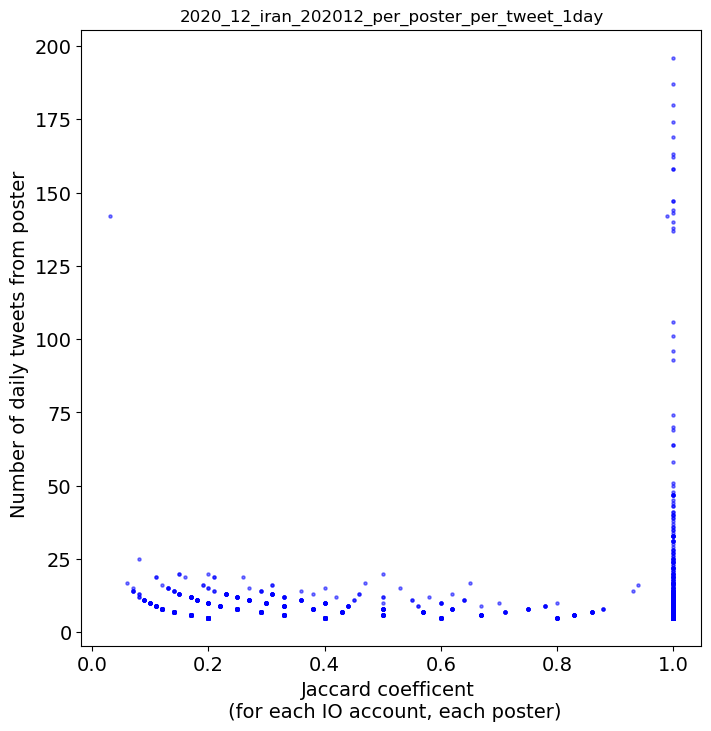

In [71]:
parameters =  {
    'data': df_jaccard,
    'fontsize': 14,
    'columns': {
        'x': 'ratio',
        'y': 'count_total_replies',
    },
    'alpha': 0.5,
    'marker_size': 5,
    'marker': None,
    'xlabel': 'Jaccard coefficent \n (for each IO account, each poster)',
    'ylabel': 'Number of daily tweets from poster  ',
    'legend_location': '',
    'log_yscale': False,
    'log_xscale': False,
    'bins': None,
    'title': f'{year}_{campaign}_per_poster_per_tweet_1day',
    'save': {
        'path': f'{time_plot_path}',
        'filename': f'{year}_{campaign}_jaccard_1day.png'
    },
}
    
scatter_plot(parameters)


In [73]:
def scatter_plot(parameters):
    '''
    Plots the scatterplot
    :param parameters: parameters for the plot
    '''
    
    # parameters =  {
    #     'data': df_jaccard,
    #     'fontsize': 14,
    #     'columns': {
    #         'x': 'ratio',
    #         'y': 'count_total_replies',
    #     },
    #     'alpha': 0.5,
    #     'marker_size': 5,
    #     'marker': None,
    #     'xlabel': 'Jaccard coefficent \n (for each IO account, each poster)',
    #     'ylabel': 'Number of daily tweets from poster  ',
    #     'legend_location': '',
    #     'log_yscale': False,
    #     'log_xscale': False,
    #     'bins': None,
    #     'title': f'{year}_{campaign}_per_poster_per_tweet_1day',
    #     'save': {
    #         'path': f'{time_plot_path}',
    #         'filename': f'{year}_{campaign}_jaccard_1day.png'
    #     },
    # }
    
    keys = parameters.keys()
    fig, ax = plt.subplots(figsize=(8, 8))
    fontsize = parameters['fontsize']
    
    colors = ['blue', 'red', 'green', 'orange', 'olive', 'pink', 'lime', 'maroon']
    symbols = ['.', 'o', '+', 'x', '*', 'v', '^', '>']
    
    x_column = parameters['columns']['x']
    y_column = parameters['columns']['y']
    data = parameters['data']
    color = colors[0]
    
    alpha = parameters['alpha'] if 'alpha' in keys else 0.5
    marker_size = parameters['marker_size'] if 'marker_size' in keys else 3
    
    if 'marker' in keys:
        marker = symbols[1]
    else:
        marker = symbols[0]
        
    ax.scatter(data[x_column], 
               data[y_column], 
               marker_size, 
               c=color, 
               alpha=alpha, 
               marker=marker,
           label="Luck")

    ax.set_xlabel(parameters['xlabel'], 
                  fontsize=fontsize)
    ax.set_ylabel(parameters['ylabel'], 
                  fontsize=fontsize)

    ax.tick_params(axis='both', labelsize=fontsize) 
    
    if 'log_yscale' in keys and parameters['log_yscale'] == True:
        ax.set_yscale('log')
    if 'log_xscale' in keys and parameters['log_xscale'] == True:
        ax.set_xscale('log')
        
    if 'title' in keys:
        plt.title(parameters['title'])

    if 'save' in keys:
        path = parameters['save']['path']
        filename = parameters['save']['filename']
        
        file_path = os.path.join(path, filename)
        
        fig.savefig(f'{file_path}', 
              facecolor='white', 
              transparent=False)
        
    plt.show()


#### **Manually inspect each user each day replies**

In [74]:
day_poster_gt_5 = df_iran.merge(df_day[['in_reply_to_userid', 
                                      'tweet_time_year']],
                              on=['in_reply_to_userid', 
                                  'tweet_time_year'],
                              how='inner')

In [31]:
##################################################

##### **How many unique posters and cpnversations were there in data sets?**

In [32]:
print('Number of unique poster in dataset :', 
      df_day['in_reply_to_userid'].nunique())


tweet_unique = df_iran.loc[
    df_iran['in_reply_to_userid'].isin(
        df_day['in_reply_to_userid'])]['in_reply_to_tweetid']
                
print('Number of unique replied to tweetids in dataset :', 
      len(set(tweet_unique)))
      

Number of unique poster in dataset : 510
Number of unique replied to tweetids in dataset : 26487


In [33]:
df_day = df_day.sort_values(by=['count'],
                            ascending=False
                           )

In [34]:
df_filter_higher = df_iran.loc[
    df_iran['in_reply_to_userid'].isin(
        df_day['in_reply_to_userid'])]

df_day_tweets = df_day.merge(df_filter_higher[['in_reply_to_tweetid',
                                               'in_reply_to_userid'
                                              ]])
df_day_tweets = df_day_tweets.sort_values(by=['count'],
                                          ascending=False)

df_save = df_day_tweets[['in_reply_to_userid', 'in_reply_to_tweetid']]
df_save = df_save.drop_duplicates().reset_index(drop=True)

In [35]:
threshold = 500

rows = df_save.iloc[:threshold]['in_reply_to_tweetid']

file_name = f'{threshold}_{campaign}_{type_of}_conversation_ids.txt'
conversation_path = os.path.join(derived_path, 
                                 'conversation')

file_hp.write_to_file_row_each_line(conversation_path, 
                                        file_name,
                                        rows)

In [36]:
df_save.iloc[:threshold]

,in_reply_to_userid,in_reply_to_tweetid
0,1169137349508382720,1260249122931523584
1,1169137349508382720,1262366717570777088
2,1169137349508382720,1262373337730297856
3,1169137349508382720,1261583279020314624
4,1169137349508382720,1261233813532766208
...,...,...
495,1169137349508382720,1220654599549440000
496,1169137349508382720,1260593661407932416
497,1169137349508382720,1263104316123971584
498,1169137349508382720,1261594609186029568
